In [ ]:
from google.colab import files
files.upload()  

import os
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.31G/6.31G [04:44<00:00, 24.8MB/s]
100% 6.31G/6.31G [04:44<00:00, 23.8MB/s]


In [3]:
import zipfile
with zipfile.ZipFile("histopathologic-cancer-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("target_directory")


In [4]:
# Import necessary libraries
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")



Using device: cuda


In [5]:
# Dataset Class for Histopathologic Cancer Detection
class HistopathologicDataset(Dataset):
    def __init__(self, csv_file, folder, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.folder = folder
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.folder, row['id'] + '.tif')
        target = row['label']
        image = cv2.imread(img_path)[:, :, ::-1]  # Convert BGR to RGB

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)


In [6]:
# Define data paths
data_dir = '/content/target_directory'
train_images_path = os.path.join(data_dir, 'train')
train_csv_path = os.path.join(data_dir, 'train_labels.csv')

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
full_dataset = HistopathologicDataset(csv_file=train_csv_path, folder=train_images_path, transform=transform)


In [7]:
# Split dataset into 80% train and 20% validation
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")


Training samples: 176020, Validation samples: 44005


In [8]:
# Model definition (ResNet18 with modifications)
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers

    model.fc = nn.Sequential(
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
    return model.to(device)

model = get_model()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.1MB/s]


In [9]:
# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, total_acc = 0, 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        total_acc += (preds == targets).sum().item() / len(targets)

    return total_loss / len(loader), total_acc / len(loader)


# Validation function
def validate_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device).unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            total_acc += (preds == targets).sum().item() / len(targets)

    return total_loss / len(loader), total_acc / len(loader)


In [10]:
# Training loop
n_epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(n_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_epoch(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch + 1}/{n_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")


Epoch 1/10
Train Loss: 0.3575, Train Accuracy: 0.8446
Val Loss: 0.2934, Val Accuracy: 0.8765
Epoch 2/10
Train Loss: 0.3232, Train Accuracy: 0.8624
Val Loss: 0.2752, Val Accuracy: 0.8872
Epoch 3/10
Train Loss: 0.3140, Train Accuracy: 0.8670
Val Loss: 0.2836, Val Accuracy: 0.8816
Epoch 4/10
Train Loss: 0.3053, Train Accuracy: 0.8717
Val Loss: 0.2815, Val Accuracy: 0.8832
Epoch 5/10
Train Loss: 0.2995, Train Accuracy: 0.8734
Val Loss: 0.2677, Val Accuracy: 0.8900
Epoch 6/10
Train Loss: 0.2952, Train Accuracy: 0.8766
Val Loss: 0.2685, Val Accuracy: 0.8905
Epoch 7/10
Train Loss: 0.2943, Train Accuracy: 0.8765
Val Loss: 0.2606, Val Accuracy: 0.8950
Epoch 8/10
Train Loss: 0.2907, Train Accuracy: 0.8790
Val Loss: 0.2644, Val Accuracy: 0.8923
Epoch 9/10
Train Loss: 0.2867, Train Accuracy: 0.8806
Val Loss: 0.2570, Val Accuracy: 0.8960
Epoch 10/10
Train Loss: 0.2851, Train Accuracy: 0.8813
Val Loss: 0.2555, Val Accuracy: 0.8965


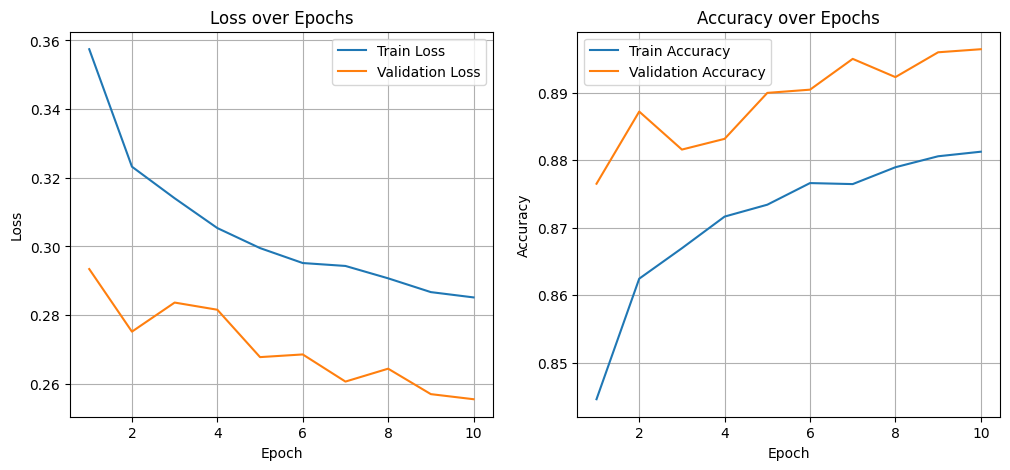

In [11]:
# Plotting results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accs, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.show()
